<a href="https://colab.research.google.com/github/johanhoffman/DD2365-VT20/blob/LindeBee/Project/projectV4_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project part 1: velocity field**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [7]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot
import math

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define 3 different domains**

*   4 by 4 perpendicular grid
*   diamond grid
*   Concentric circular grid

In [0]:
def grid(L,H,theta=0):
  theta = math.radians(theta)
  domain = Rectangle(Point(-L/2,-H/2), Point(L/2,H/2))
  for i in range (0,4):
    a = -4.43+i*2.415
    b = a+1.615
    for j in range(0,4):
      c = -4.43+j*2.415
      d = c+1.615
      domain -= Polygon([Point(a*cos(theta)-c*sin(theta),a*sin(theta)+c*cos(theta)), \
                         Point(b*cos(theta)-c*sin(theta),b*sin(theta)+c*cos(theta)), \
                         Point(b*cos(theta)-d*sin(theta),b*sin(theta)+d*cos(theta)), \
                         Point(a*cos(theta)-d*sin(theta),a*sin(theta)+d*cos(theta))])
  return domain

def skewed(L,H,theta=0):
  theta = math.radians(theta)
  domain = Rectangle(Point(-L/2,-H/2), Point(L/2,H/2))
  alpha = math.radians(35)
  str_w = 0.6
  shape_w = 1.2
  shape_h = shape_w*tan(alpha)
  dhor= str_w/(cos(alpha)*sin(alpha))
  dver = str_w/(2*cos(alpha))
  print(shape_h)
  for i in range (0,7):
    a = -3.5
    b = -4.43+i*(shape_h+dver)
    if (i%2 == 0):
        num_shapes = 3
    else:
        num_shapes = 2
        a += (shape_w+dhor/2)
    for j in range(0,num_shapes):
      c = a+shape_w
      d = b+shape_h
      e = b+2*shape_h
      f = a-shape_w
      domain -= Polygon([Point(a*cos(theta)-b*sin(theta),a*sin(theta)+b*cos(theta)), \
                         Point(c*cos(theta)-d*sin(theta),c*sin(theta)+d*cos(theta)), \
                         Point(a*cos(theta)-e*sin(theta),a*sin(theta)+e*cos(theta)), \
                         Point(f*cos(theta)-d*sin(theta),f*sin(theta)+d*cos(theta))])
      a += 2*shape_w + dhor
  return domain

def concentric(L,H, theta=0):
  theta = math.radians(theta)
  domain = Rectangle(Point(-L/2,-H/2), Point(L/2,H/2))
  for i in range (0,12):
    alpha = i*2*pi/12+theta
    beta = (i+1)*2*pi/12+theta
    domain -= Polygon([Point(5*cos(alpha), 5*sin(alpha)), \
                       Point(5*cos(beta), 5*sin(beta)), \
                       Point(3*cos(beta), 3*sin(beta)), \
                       Point(3*cos(alpha), 3*sin(alpha))])
  for i in range (0,12):
    alpha = i*2*pi/12+theta
    dx = cos(alpha-pi/2) * 0.4
    dy = sin(alpha-pi/2) * 0.4
    domain += Polygon([Point(6*cos(alpha)+dx,6*sin(alpha)+dy), \
                       Point(6*cos(alpha)-dx,6*sin(alpha)-dy), \
                       Point(-dx,-dy),Point(dx,dy)])
  domain -= Circle(Point(0,0), 2.0)
  for i in range (0,4):
    alpha = i*2*pi/4+theta
    dx = cos(alpha-pi/2) * 0.4
    dy = sin(alpha-pi/2) * 0.4
    domain += Polygon([Point(2.6*cos(alpha)+dx,2.6*sin(alpha)+dy), \
                       Point(2.6*cos(alpha)-dx,2.6*sin(alpha)-dy), \
                       Point(-dx,-dy),Point(dx,dy)])
  return domain

**Define domain and mesh**

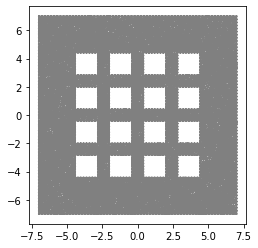

In [10]:
# Define rectangular domain 
L = 14
H = 14

# Define circle
xc = 0.5*L
yc = 0.5*H
rc = 1.

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], -L/2) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L/2)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], -H/2)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H/2)

class Freeslip(SubDomain):
    def inside(self, x, on_boundary):
        return (on_boundary and (not near(x[0], -L/2)) and (not near(x[0], L/2)) \
                and (not near(x[1], -H/2)) and (not near(x[1], H/2)))
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()
freeslip = Freeslip()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 64
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
# mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) \
#         - Circle(Point(xc,yc),rc) , resolution)

!rm Grid_0/*
domain = grid(L,H,0)
mesh = generate_mesh(domain, resolution)
saved_mesh = File("Grid_0/mesh.xml")
saved_mesh << mesh
timeseries_u = TimeSeries('Grid_0/velocity_series')

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 0.5:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)
freeslip.mark(boundaries, 5)
fs = 5

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [11]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


**Define boundary conditions**

In [0]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], -H/2)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H/2)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], -L/2) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L/2)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], -L/2)) and (not near(x[0], L/2)) and (not near(x[1], -H/2)) and (not near(x[1], H/2))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left) 
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1]
bcp = [bcp1]

# Define measure for boundary integration  
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

In [0]:
# # inflow and outflow conditions
# XMIN = 0.0; XMAX = L
# YMIN = 0.0; YMAX = H

# # define uin of size 1 for different angles: 0, pi/6, pi/3, pi/2
# # angle = 0
# # uin_x = cos(angle)
# # uin_y = sin(angle)
# # uin = Expression(("uin_x", "uin_y"), uin_x=uin_x, uin_y=uin_y, element = V.ufl_element()) 
# # pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
# # pout = 0.0

# # Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
# ib = Expression("near(x[0],XMIN) || near(x[1],YMIN) ? 1. : 0.", XMIN=XMIN, YMIN=YMIN, element = Q.ufl_element())
# ob = Expression("near(x[0],XMAX) || near(x[1], YMAX) ? 1. : 0.", XMAX=XMAX, YMAX=YMAX, element = Q.ufl_element()) 
# wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN,YMAX=YMAX, element = Q.ufl_element())

# **Results**

**Define flow parameters**

In [0]:
# Set viscosity
nu = 4e-10

**Define method parameters**

In [0]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers 
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length (try shorter)
dt = 0.5*mesh.hmin() 

**Define variational problem**

In [0]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
#increase for more stability
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag
C = 1.0e3
gamma = C/h
n = FacetNormal(mesh)

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx \
    + gamma*(inner(dot(u,n), dot(v,n)))*ds(fs)
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

/usr/local/lib/python3.6/dist-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.6/dist-packages/matplotlib/quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.6/dist-packages/matplotlib/quiver.py:767: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/usr/local/lib/python3.6/dist-packages/matplotlib/quiver.py:780: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


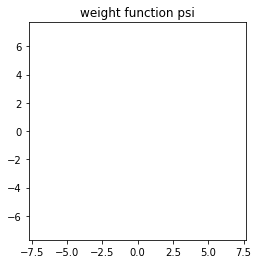

In [17]:
# Define the direction of the force to be computed 
phi_x = 0.0
phi_y = 1.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

plt.figure()
plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [0]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Force computation data 
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.07073746924398669


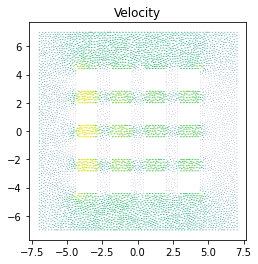

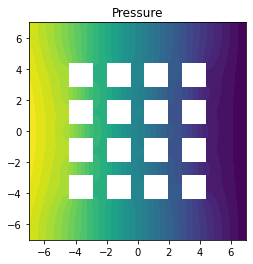

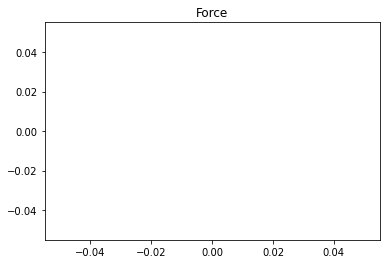

Time t = 0.6366372231958803


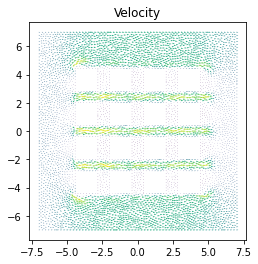

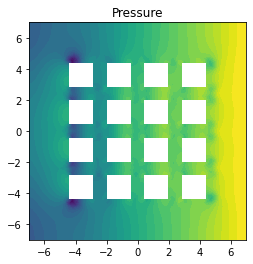

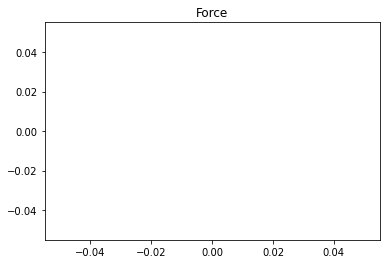

Time t = 1.2025369771477739


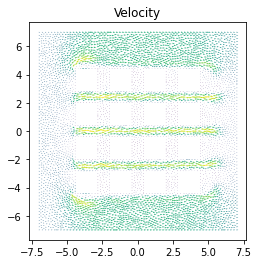

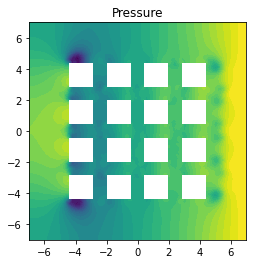

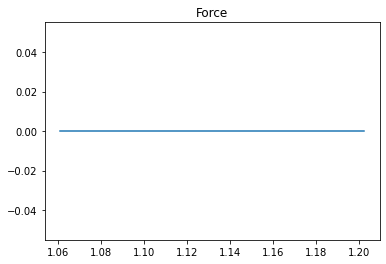

Time t = 1.8391742003436533


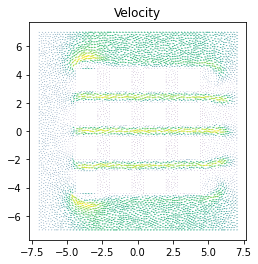

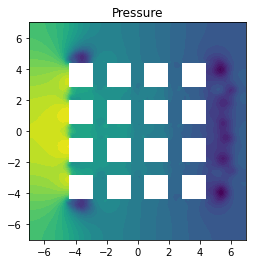

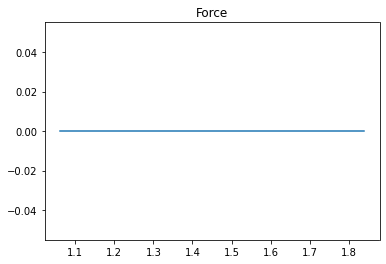

Time t = 2.4050739542955464


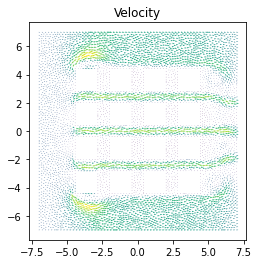

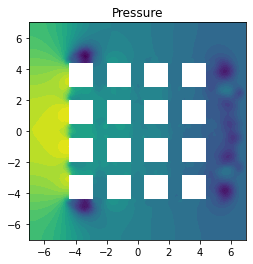

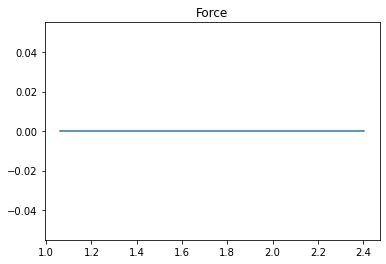

Time t = 3.041711177491426


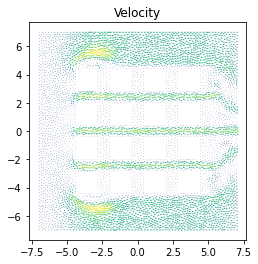

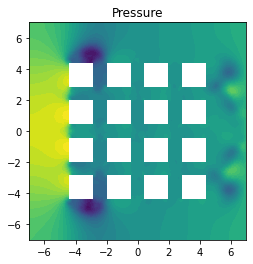

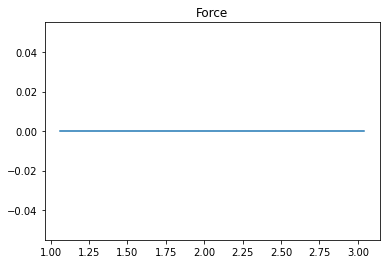

Time t = 3.6076109314433187


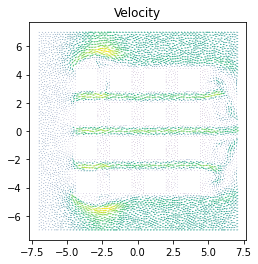

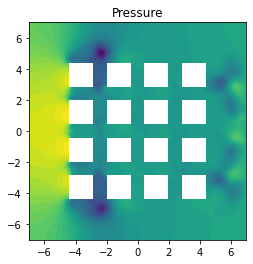

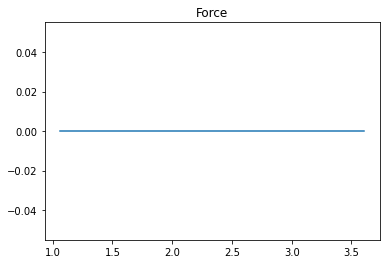

Time t = 4.2442481546392


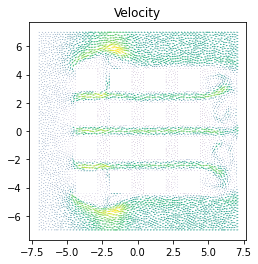

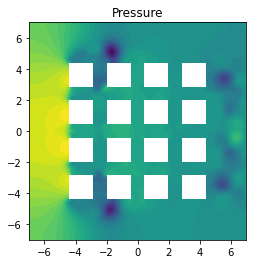

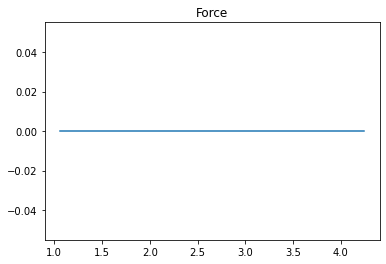

Time t = 4.810147908591096


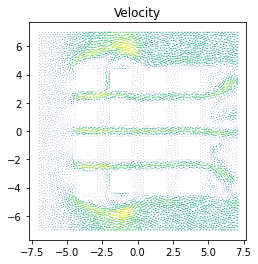

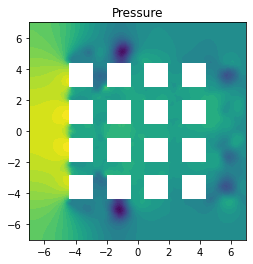

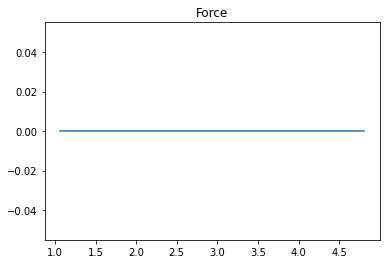

Time t = 5.44678513178698


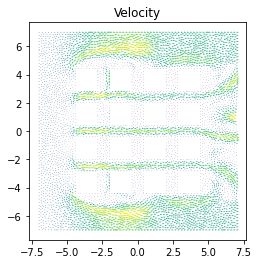

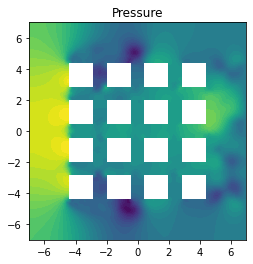

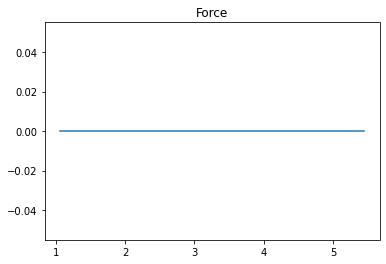

Grid_0/
Grid_0/velocity_series.h5
Grid_0/mesh.xml


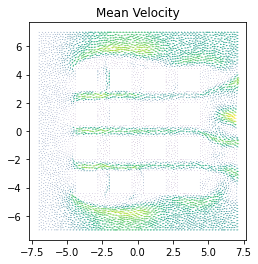

In [19]:

# Time stepping 
T = 6
t = dt
u_mean = Constant((0.0,0.0))
num = 0
t_t = 0

while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute pressure solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F = assemble(Force)
        if (t > start_sample_time):
          force_array = np.append(force_array, normalization*F)
          time = np.append(time, t)

        k += 1

    if t>3:
        timeseries_u.store(u1.vector(), t_t)
        t_t += dt

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        # file_u << u1
        # file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq
        
        plt.show()

        plt.figure()
        plt.title("Force")
        plt.plot(time, force_array)
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

# u_mean = u_mean/num

plt.figure()
plot(u1, title="Mean Velocity")

# !tar -czvf results.tar.gz Grid_0
# files.download('results.tar.gz')

In [0]:
# Save solution
# u_sol = project(u_mean,V)
# output_file = HDF5File(mesh.mpi_comm(), "u_c_10.h5", "w")
# output_file.write(u_sol, "solution")
# output_file.close()

# Load solution
# U = Function(V)
# input_file = HDF5File(mesh.mpi_comm(), "u_c_0.h5", "r")
# input_file.read(U, "solution")
# input_file.close()

# plt.figure()
# plot(U, title="Mean Velocity")

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)